## STopover_imageST sample code (Xenium)

### Load STopover & Prepare

In [1]:
%%time
import os
import sys
sys.path.insert(1, '/home/nmadmin/DATA2/STopover')

CPU times: user 18 µs, sys: 7 µs, total: 25 µs
Wall time: 27.2 µs


In [2]:
import os
import pandas as pd
import numpy as np
import scanpy as sc

In [3]:
from STopover import STopover_imageST

### Download Lung Adenocarcinoma (LUAD) VisiumHD dataset

https://www.10xgenomics.com/datasets/human-lung-cancer-preview-data-xenium-human-multi-tissue-and-cancer-panel-1-standard

In [4]:
# Output Files
!wget -P ./data/VisiumHD_LUAD https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_web_summary.html
!wget -P ./data/VisiumHD_LUAD https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_feature_slice.h5
!wget -P ./data/VisiumHD_LUAD https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_metrics_summary.csv
!wget -P ./data/VisiumHD_LUAD https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_molecule_info.h5
!wget -P ./data/VisiumHD_LUAD https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_spatial.tar.gz
!wget -P ./data/VisiumHD_LUAD https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_binned_outputs.tar.gz

--2024-09-21 17:28:59--  https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_web_summary.html
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./data/VisiumHD_LUAD/Visium_HD_Human_Lung_Cancer_web_summary.html’

Visium_HD_Human_Lun     [  <=>               ]  26.32M  97.8MB/s    in 0.3s    

2024-09-21 17:28:59 (97.8 MB/s) - ‘./data/VisiumHD_LUAD/Visium_HD_Human_Lung_Cancer_web_summary.html’ saved [27595650]

--2024-09-21 17:29:00--  https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer/Visium_HD_Human_Lung_Cancer_feature_slice.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xg

In [6]:
# Unzip File
!for file in ./data/VisiumHD_LUAD/*.tar.gz; do tar -xvzf "$file" -C ./data/VisiumHD_LUAD/; done

binned_outputs/
binned_outputs/square_002um/
binned_outputs/square_002um/filtered_feature_bc_matrix/
binned_outputs/square_002um/filtered_feature_bc_matrix/matrix.mtx.gz
binned_outputs/square_002um/filtered_feature_bc_matrix/features.tsv.gz
binned_outputs/square_002um/filtered_feature_bc_matrix/barcodes.tsv.gz
binned_outputs/square_002um/filtered_feature_bc_matrix.h5
binned_outputs/square_002um/raw_feature_bc_matrix/
binned_outputs/square_002um/raw_feature_bc_matrix/matrix.mtx.gz
binned_outputs/square_002um/raw_feature_bc_matrix/features.tsv.gz
binned_outputs/square_002um/raw_feature_bc_matrix/barcodes.tsv.gz
binned_outputs/square_002um/raw_feature_bc_matrix.h5
binned_outputs/square_002um/raw_probe_bc_matrix.h5
binned_outputs/square_002um/spatial/
binned_outputs/square_002um/spatial/aligned_fiducials.jpg
binned_outputs/square_002um/spatial/aligned_tissue_image.jpg
binned_outputs/square_002um/spatial/cytassist_image.tiff
binned_outputs/square_002um/spatial/detected_tissue_image.jpg
binn

### Load single-cell RNA-seq dataset for LUAD

##### Read single-cell dataset (GSE131907) with cell type annotation in .obs as 'Cell_subtype'

In [4]:
sc_adata = sc.read_h5ad('./data/sc_lung_cancer.h5ad')

In [5]:
sc_adata = sc_adata[sc_adata.obs['Sample_Origin']=='tLung']

In [6]:
sc_adata

View of AnnData object with n_obs × n_vars = 45149 × 29634
    obs: 'Barcode', 'Sample', 'Sample_Origin', 'Cell_type', 'Cell_type.refined', 'Cell_subtype'

##### Reassign Undetermined and NaN in 'Cell_subtype' into _ns subtype

In [7]:
sc_adata.obs['Cell_subtype'] = sc_adata.obs['Cell_subtype'].astype(object)
sc_adata.obs['Cell_type'] = sc_adata.obs['Cell_type'].astype(object)

sc_adata.obs['Cell_subtype'] = sc_adata.obs['Cell_subtype'].where(sc_adata.obs['Cell_subtype'].ne('Undetermined'), sc_adata.obs['Cell_type']+'_ns')
sc_adata.obs['Cell_subtype'] = sc_adata.obs['Cell_subtype'].fillna(sc_adata.obs['Cell_type']+'_ns')

In [8]:
sc_adata.obs

Barcode    Sample Sample_Origin  \
AAACCTGAGACGACGT_LUNG_T09  AAACCTGAGACGACGT  LUNG_T09         tLung   
AAACCTGAGACGACGT_LUNG_T34  AAACCTGAGACGACGT  LUNG_T34         tLung   
AAACCTGAGACGCTTT_LUNG_T18  AAACCTGAGACGCTTT  LUNG_T18         tLung   
AAACCTGAGACTGTAA_LUNG_T34  AAACCTGAGACTGTAA  LUNG_T34         tLung   
AAACCTGAGATATGCA_LUNG_T25  AAACCTGAGATATGCA  LUNG_T25         tLung   
...                                     ...       ...           ...   
TTTGTCATCTCACATT_LUNG_T31  TTTGTCATCTCACATT  LUNG_T31         tLung   
TTTGTCATCTGCGACG_LUNG_T31  TTTGTCATCTGCGACG  LUNG_T31         tLung   
TTTGTCATCTTGCCGT_LUNG_T30  TTTGTCATCTTGCCGT  LUNG_T30         tLung   
TTTGTCATCTTTACAC_LUNG_T25  TTTGTCATCTTTACAC  LUNG_T25         tLung   
TTTGTCATCTTTAGGG_LUNG_T31  TTTGTCATCTTTAGGG  LUNG_T31         tLung   

                                  Cell_type Cell_type.refined  \
AAACCTGAGACGACGT_LUNG_T09     Myeloid cells     Myeloid cells   
AAACCTGAGACGACGT_LUNG_T34     B lymphocytes     B lymphocytes   
AAACCTGAGACGCTTT_LUNG_T18  Epithelial cells  Epithelial cells   
AAACCTGAGACTGTAA_LUNG_T34  Epithelial cells  Epithelial cells   
AAACCTGAGATATGCA_LUNG_T25     T lymphocytes        T/NK cells   
...                                     ...               ...   
TTTGTCATCTCACATT_LUNG_T31     T lymphocytes        T/NK cells   
TTTGTCATCTGCGACG_LUNG_T31       Fibroblasts               NaN   
TTTGTCATCTTGCCGT_LUNG_T30  Epithelial cells  Epithelial cells   
TTTGTCATCTTTACAC_LUNG_T25     B lymphocytes     B lymphocytes   
TTTGTCATCTTTAGGG_LUNG_T31  Epithelial cells  Epithelial cells   

                                 Cell_subtype  
AAACCTGAGACGACGT_LUNG_T09           CD1c+ DCs  
AAACCTGAGACGACGT_LUNG_T34  Follicular B cells  
AAACCTGAGACGCTTT_LUNG_T18                 tS2  
AAACCTGAGACTGTAA_LUNG_T34                 tS2  
AAACCTGAGATATGCA_LUNG_T25             CD4+ Th  
...                                       ...  
TTTGTCATCTCACATT_LUNG_T31  CD8+/CD4+ Mixed Th  
TTTGTCATCTGCGACG_LUNG_T31      Fibroblasts_ns  
TTTGTCATCTTGCCGT_LUNG_T30                 tS1  
TTTGTCATCTTTACAC_LUNG_T25  Follicular B cells  
TTTGTCATCTTTAGGG_LUNG_T31                 tS2  

[45149 rows x 6 columns]

### Create STopover_imageST object  
#### (annotate cells & convert to grid-based data)

In [9]:
save_dir = './results/Xenium_LUAD'
os.makedirs(save_dir, exist_ok=True)

In [10]:
help(STopover_imageST)

Help on class STopover_imageST in module STopover.STopover_class:

class STopover_imageST(STopover_visium)
 |  STopover_imageST(sp_adata=None, annotate_sp_adata=False, sp_load_path='.', sc_adata=None, sc_celltype_colname='celltype', ST_type='cosmx', grid_method='transcript', annot_method='tacco', sc_norm_total=1000.0, min_counts=10, min_cells=5, tx_file_name='tx_file.csv', cell_exprmat_file_name='exprMat_file.csv', cell_metadata_file_name='metadata_file.csv', fov_colname='fov', cell_id_colname='cell_ID', tx_xcoord_colname='x_global_px', tx_ycoord_colname='y_global_px', transcript_colname='target', meta_xcoord_colname='CenterX_global_px', meta_ycoord_colname='CenterY_global_px', x_bins=100, y_bins=100, min_size=20, fwhm=2.5, thres_per=30, save_path='.', J_count=0)
 |  
 |  ## Class to calculate connected component location and jaccard similarity indices in image-based ST dataset
 |  
 |  ### Input
 |  sp_adata: Anndata object for image-based ST data with count matrix ('raw') in .X
 |  a

In [11]:
data_path = './data/Xenium_LUAD'

In [12]:
cell_meta = pd.read_csv(os.path.join(data_path, 'cells.csv.gz'))

In [13]:
cell_meta

cell_id   x_centroid   y_centroid  transcript_counts  \
0       aaaanamo-1    72.845871   849.649963                 53   
1       aaabfigf-1    96.823967   861.536377                119   
2       aaabkdpm-1   118.609566   852.812805                150   
3       aaackcjc-1    34.003616   857.918091                 49   
4       aaadajdo-1   148.912018   844.489319                 44   
...            ...          ...          ...                ...   
150360  oikdcdpk-1  9103.792969  2588.266846                 83   
150361  oikdkded-1  9114.743164  2594.548340                 34   
150362  oikdnkno-1  9149.015625  2593.347900                 52   
150363  oikdofbi-1  9150.145508  2568.765869                 32   
150364  oikdojno-1  9146.358398  2584.576172                 88   

        control_probe_counts  control_codeword_counts  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        0   
4                          0                        0   
...                      ...                      ...   
150360                     0                        0   
150361                     0                        0   
150362                     0                        0   
150363                     0                        0   
150364                     0                        0   

        unassigned_codeword_counts  deprecated_codeword_counts  total_counts  \
0                                0                           0            53   
1                                0                           0           119   
2                                0                           0           150   
3                                0                           0            49   
4                                0                           0            44   
...                            ...                         ...           ...   
150360                           0                           0            83   
150361                           0                           0            34   
150362                           0                           0            52   
150363                           0                           0            32   
150364                           0                           0            88   

         cell_area  nucleus_area  
0       729.408933     15.488594  
1       803.510342     24.881095  
2       750.722684     19.326876  
3       596.107678      4.605938  
4       507.556268      6.412188  
...            ...           ...  
150360  224.516883     34.905783  
150361   87.241878     28.132345  
150362   82.048909     18.017344  
150363  100.653285     19.417188  
150364  151.137974     37.118439  

[150365 rows x 11 columns]

In [14]:
sp_adata = STopover_imageST(sp_load_path=data_path, sc_adata=sc_adata, sc_celltype_colname = 'Cell_subtype', 
                            ST_type='xenium', grid_method='cell', annot_method='tacco', sc_norm_total=1e3,
                            cell_exprmat_file_name='cell_feature_matrix.h5', 
                            cell_metadata_file_name='cells.csv.gz', 
                            cell_id_colname='cell_id',
                            meta_xcoord_colname='x_centroid', meta_ycoord_colname='y_centroid',
                            x_bins=100, y_bins=100, min_size=20, fwhm=2.5, thres_per=30, save_path=save_dir)

Anndata object is not provided: searching for the .h5ad file in 'sp_load_path'
Failed
Reading image-based ST data files in 'sp_load_path'
End of creating image-based ST cell-level anndata: 1.21 seconds
Using 'tacco' to annotate cells with reference single-cell data
____________________________________________________________
Starting preprocessing
Annotation profiles were not found in `reference.varm["Cell_subtype"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 0.49 seconds.
Starting annotation of data with shape (148925, 364) and a reference of shape (45147, 364) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=Cell_subtype, normalize_to=adata
   +- bisection boost: bisections=4, bisection_divisor=3
      +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  302.27144042799887 2196.67991568398
bisection run on 1
bisection run on 

In [15]:
sp_adata

STopover_imageST object with n_obs × n_vars = 7881 × 377
    obs: 'array_col', 'array_row', 'Activated DCs', 'Alveolar Mac', 'B lymphocytes_ns', 'CD141+ DCs', 'CD163+CD14+ DCs', 'CD1c+ DCs', 'CD207+CD1a+ LCs', 'CD4+ Th', 'CD8 low T', 'CD8+/CD4+ Mixed Th', 'COL13A1+ matrix FBs', 'COL14A1+ matrix FBs', 'Cytotoxic CD8+ T', 'EPCs', 'Endothelial cells_ns', 'Epithelial cells_ns', 'Exhausted CD8+ T', 'Exhausted Tfh', 'Fibroblasts_ns', 'Follicular B cells', 'GC B cells in the DZ', 'GC B cells in the LZ', 'Lymphatic ECs', 'MALT B cells', 'MAST', 'Mesothelial cells', 'Monocytes', 'Myeloid cells_ns', 'Myofibroblasts', 'NK', 'NK cells_ns', 'Naive CD4+ T', 'Naive CD8+ T', 'Pericytes', 'Plasma cells', 'Pleural Mac', 'Smooth muscle cells', 'Stalk-like ECs', 'T lymphocytes_ns', 'Tip-like ECs', 'Treg', 'Tumor ECs', 'mo-Mac', 'pDCs', 'tS1', 'tS2', 'tS3'
    uns: 'tx_by_cell_grid', 'adata_cell', 'x_bins', 'y_bins', 'ST_type', 'grid_method', 'sc_celltype_colname', 'transcript_colname', 'sc_norm_total', 'm

In [16]:
sp_adata.obs

array_col  array_row  Activated DCs  Alveolar Mac  B lymphocytes_ns  \
0_4            0          4              0             0                 0   
0_5            0          5              0             0                 0   
0_6            0          6              0             0                 0   
0_7            0          7              0             0                 0   
0_8            0          8              0             0                 0   
...          ...        ...            ...           ...               ...   
97_65         97         65              0             0                 0   
97_67         97         67              0             0                 0   
98_0          98          0              0             0                 0   
99_0          99          0              1             0                 0   
99_42         99         42              0             0                 0   

       CD141+ DCs  CD163+CD14+ DCs  CD1c+ DCs  CD207+CD1a+ LCs  CD4+ Th  ...  \
0_4             0                0          0                0        0  ...   
0_5             0                0          0                0        0  ...   
0_6             0                0          0                0        0  ...   
0_7             0                0          0                0        0  ...   
0_8             0                0          0                0        0  ...   
...           ...              ...        ...              ...      ...  ...   
97_65           0                0          0                0        0  ...   
97_67           0                0          0                0        0  ...   
98_0            0                0          0                0        0  ...   
99_0            0                0          0                0        0  ...   
99_42           0                0          0                0        0  ...   

       Stalk-like ECs  T lymphocytes_ns  Tip-like ECs  Treg  Tumor ECs  \
0_4                 0                 0             0     0          0   
0_5                 0                 0             0     0          0   
0_6                 0                 0             0     0          0   
0_7                 0                 0             0     0          0   
0_8                 0                 0             0     0          0   
...               ...               ...           ...   ...        ...   
97_65               0                 0             0     0          0   
97_67               0                 0             0     0          0   
98_0                0                 0             0     1          0   
99_0                0                 0             0     0          0   
99_42               0                 0             0     0          0   

       mo-Mac  pDCs  tS1  tS2  tS3  
0_4         0     0    0    0    0  
0_5         0     0    0    0    0  
0_6         0     0    0    0    0  
0_7         0     0    0    0    0  
0_8         0     0    0    0    0  
...       ...   ...  ...  ...  ...  
97_65       0     0    0    0    0  
97_67       0     0    0    0    0  
98_0        1     0    0    0    0  
99_0        0     0    0    0    0  
99_42       0     0    0    0    0  

[7881 rows x 49 columns]

### Visualize spatial cell annotation

#### Remove cell types that end with '_ns'

In [17]:
sp_adata_cell = sp_adata.uns['adata_cell']
sp_adata_cell_sub = sp_adata_cell[~sp_adata_cell.obs['Cell_subtype'].str.contains('_ns')]

In [18]:
sp_adata_cell_sub

STopover_imageST object with n_obs × n_vars = 144116 × 377
    obs: 'cell_id', 'array_col', 'array_row', 'n_counts', 'Cell_subtype', 'grid_array_col', 'grid_array_row'
    var: 'n_cells'
    uns: 'log1p', 'x_bins', 'y_bins', 'ST_type', 'grid_method', 'sc_celltype_colname', 'transcript_colname', 'sc_norm_total', 'min_counts', 'min_cells', 'min_size', 'fwhm', 'thres_per', 'obs_'

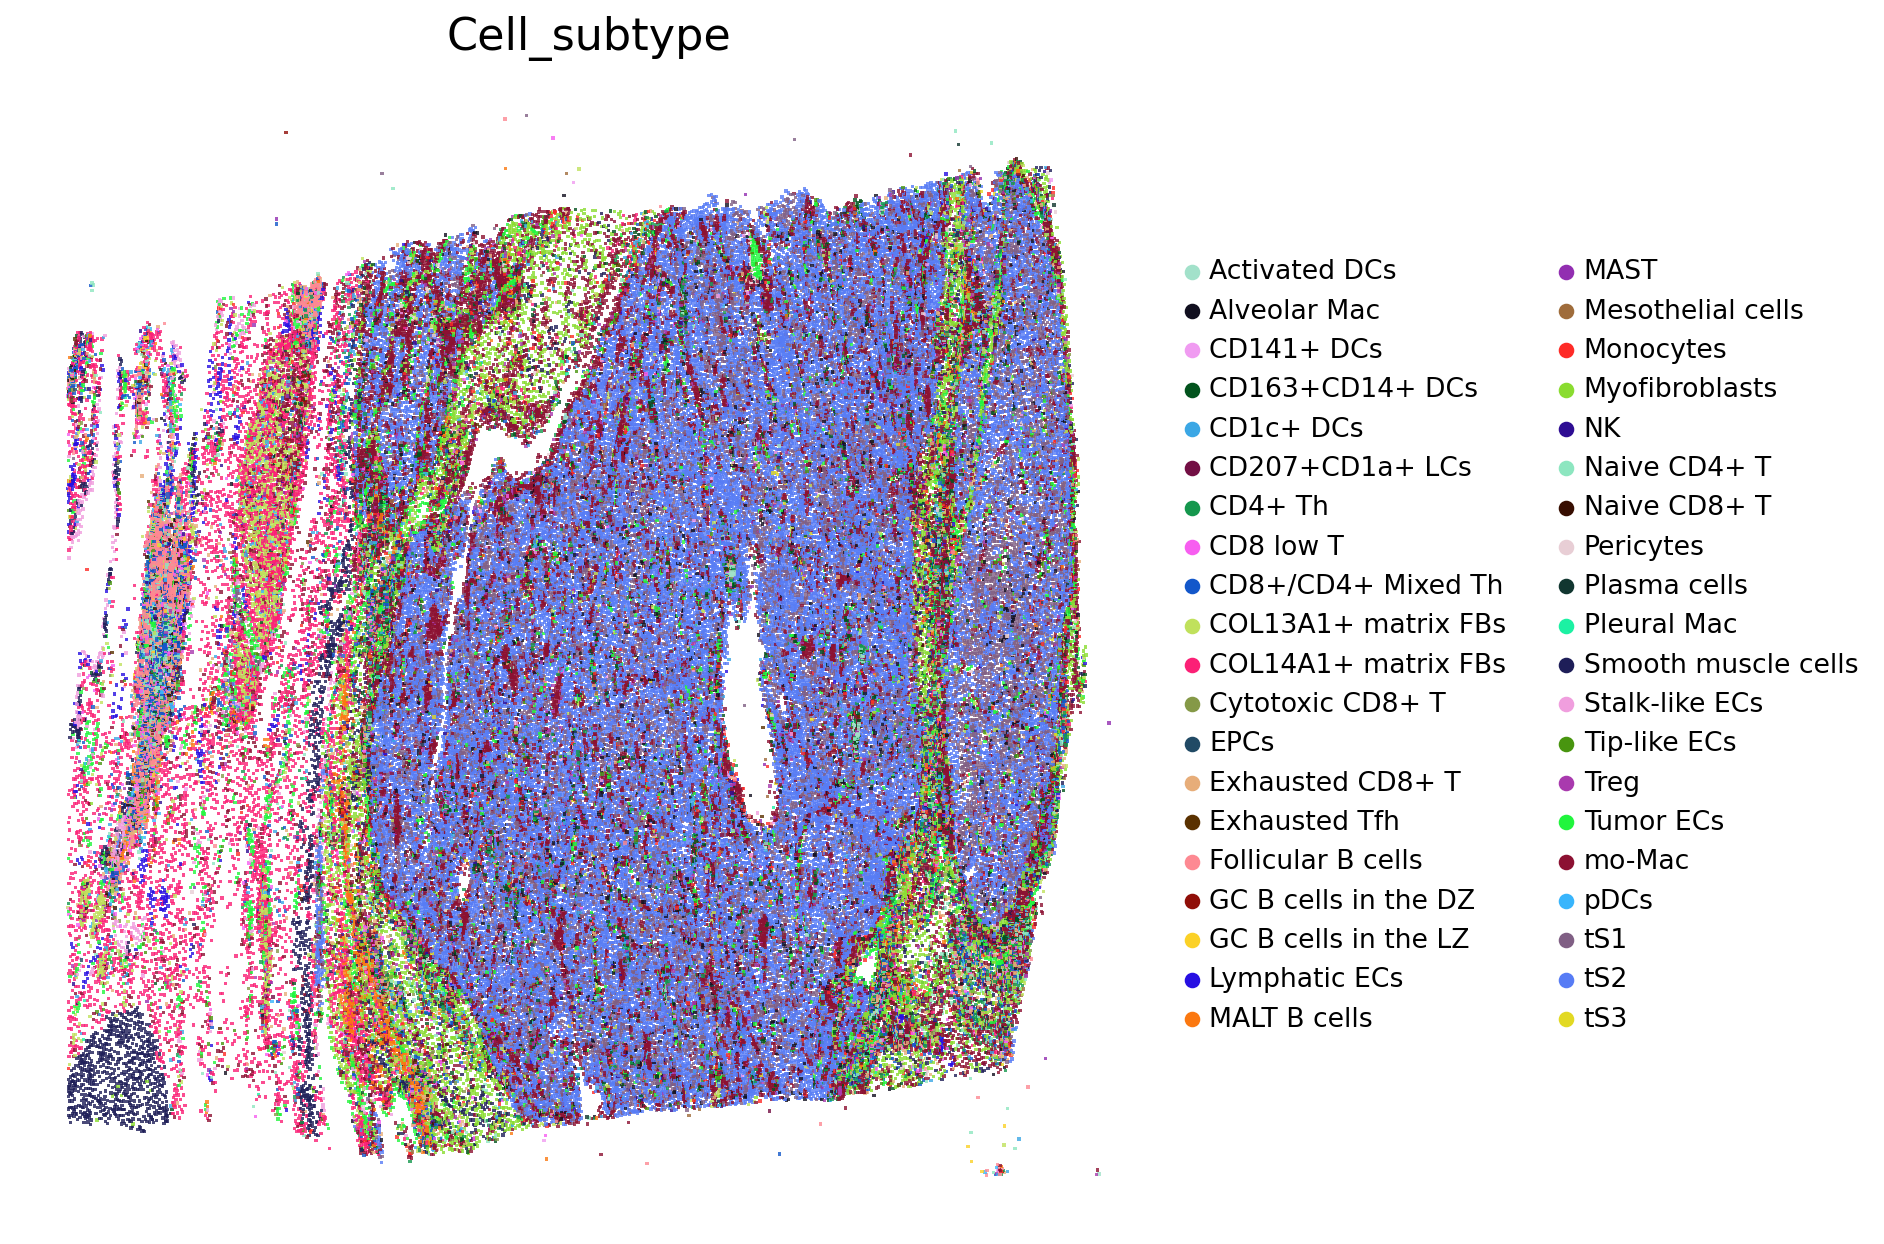

In [19]:
sp_adata_cell_sub.vis_spatial_imageST(feat_name='Cell_subtype', title_fontsize=20, dot_size=1.5,
                                      fig_size=(12,8), legend_fontsize=12, save=True, dpi=200)

### Topological similarity analysis

In [20]:
cell_subtypes_list = sp_adata.obs.columns[2:]
cell_subtypes_list

Index(['Activated DCs', 'Alveolar Mac', 'B lymphocytes_ns', 'CD141+ DCs',
       'CD163+CD14+ DCs', 'CD1c+ DCs', 'CD207+CD1a+ LCs', 'CD4+ Th',
       'CD8 low T', 'CD8+/CD4+ Mixed Th', 'COL13A1+ matrix FBs',
       'COL14A1+ matrix FBs', 'Cytotoxic CD8+ T', 'EPCs',
       'Endothelial cells_ns', 'Epithelial cells_ns', 'Exhausted CD8+ T',
       'Exhausted Tfh', 'Fibroblasts_ns', 'Follicular B cells',
       'GC B cells in the DZ', 'GC B cells in the LZ', 'Lymphatic ECs',
       'MALT B cells', 'MAST', 'Mesothelial cells', 'Monocytes',
       'Myeloid cells_ns', 'Myofibroblasts', 'NK', 'NK cells_ns',
       'Naive CD4+ T', 'Naive CD8+ T', 'Pericytes', 'Plasma cells',
       'Pleural Mac', 'Smooth muscle cells', 'Stalk-like ECs',
       'T lymphocytes_ns', 'Tip-like ECs', 'Treg', 'Tumor ECs', 'mo-Mac',
       'pDCs', 'tS1', 'tS2', 'tS3'],
      dtype='object')

#### 0. Create list of cell type pairs

In [21]:
cell_type_pairs = [(cell_subtypes_list[idx_i], cell_subtypes_list[idx_j]) \
                   for idx_i in range(len(cell_subtypes_list)) \
                   for idx_j in range(idx_i+1, len(cell_subtypes_list))]

#### 1. Extract colocalized regions between cell types

##### Extract colocalization patterns btw cell types

In [22]:
sp_adata.topological_similarity(feat_pairs=cell_type_pairs, J_result_name='result')

End of data preparation
Elapsed time: 0.16 seconds 
Calculation of adjacency matrix and mask


  0%|          | 0/1 [00:00<?, ?it/s]

Calculation of connected components for each feature


  0%|          | 0/47 [00:00<?, ?it/s]

Calculation of composite jaccard indexes between feature pairs


  0%|          | 0/1081 [00:00<?, ?it/s]

End of the whole process: 27.43 seconds


##### Save STopover object
###### Cell annotation data in sp_adata.uns['adata_cell'] is saved separately

In [23]:
sp_adata.save_connected_loc_data(save_format='h5ad', filename = 'sp_grid_celltype_interact')

Saving anndata in .uns separately as .h5ad: adata_cell


##### Visualize spatial feature map

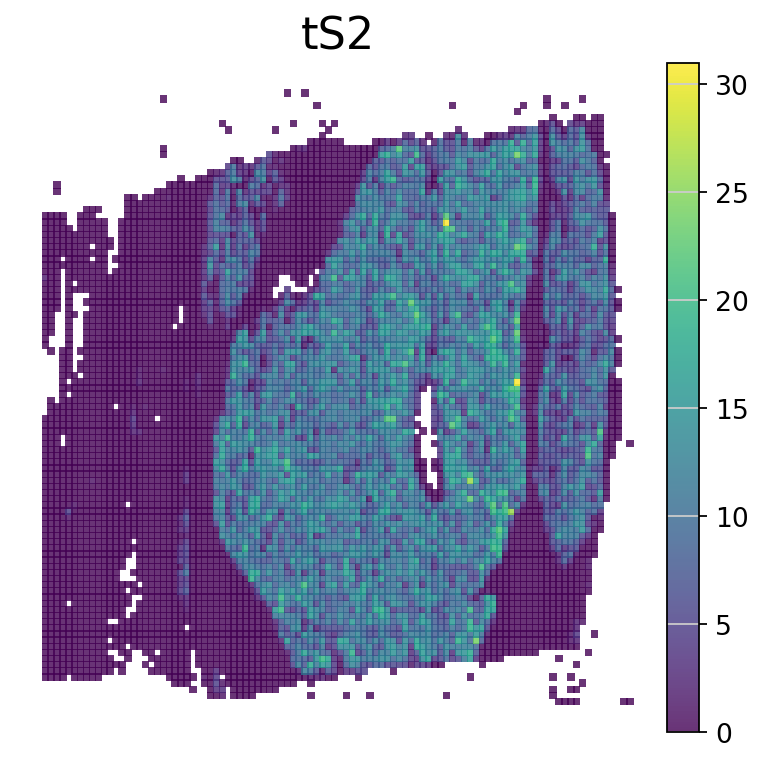

In [24]:
sp_adata.vis_spatial_imageST(feat_name='tS2', fig_size=(5,5), title_fontsize=20, 
                             legend_fontsize=12, save=True, return_axis=False, dpi=200)

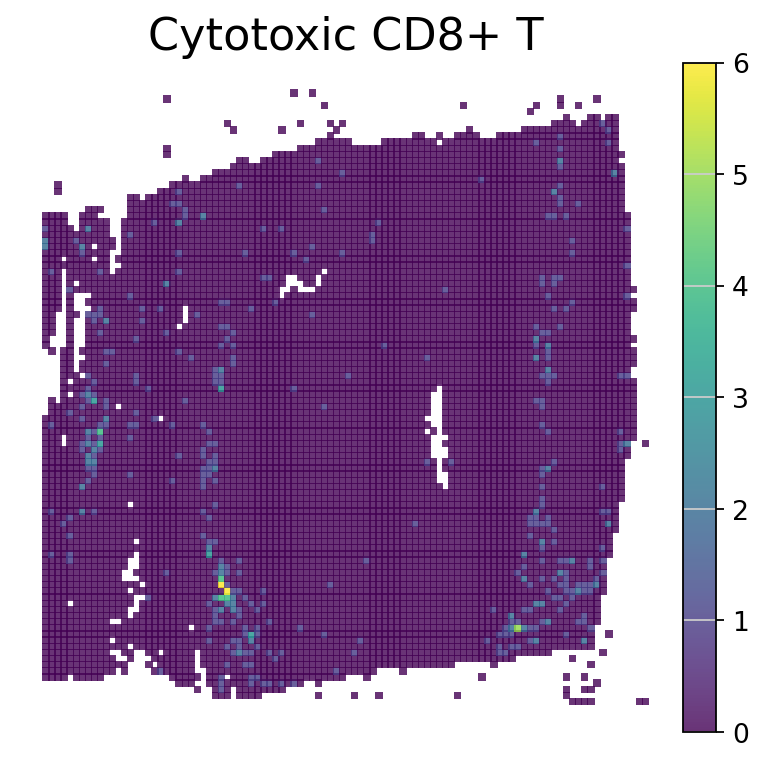

In [25]:
sp_adata.vis_spatial_imageST(feat_name='Cytotoxic CD8+ T', fig_size=(5,5), title_fontsize=20, 
                             legend_fontsize=12, save=True, return_axis=False,  dpi=200)

##### Visualize colocalized regions of a cell type pair

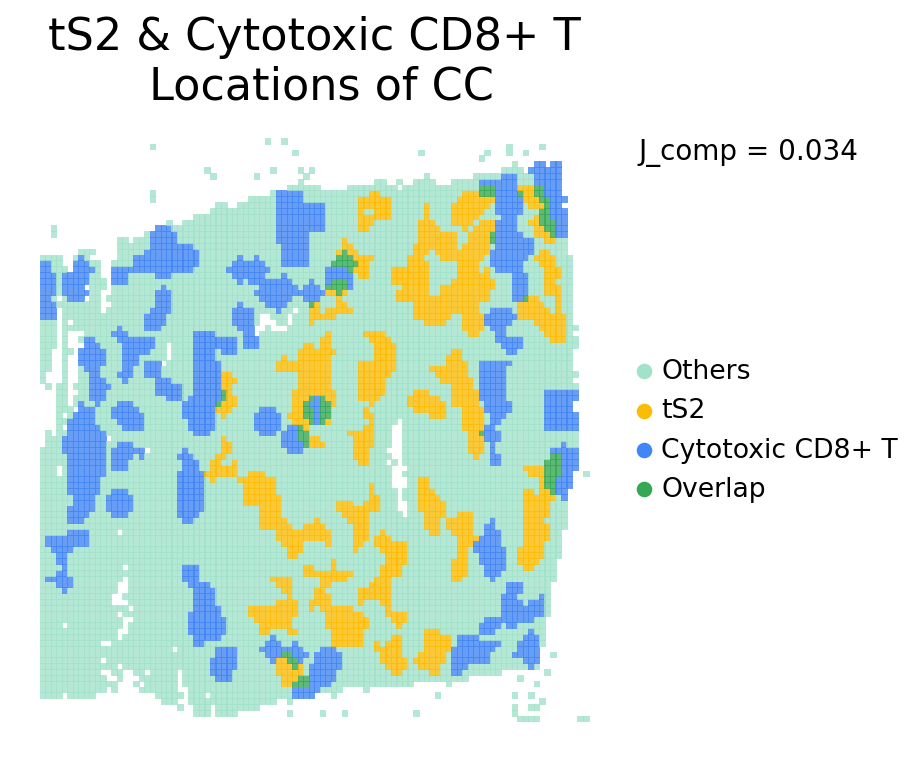

In [26]:
sp_adata.vis_all_connected(feat_name_x='tS2', feat_name_y='Cytotoxic CD8+ T',
                           alpha = 0.8, dot_size=3,
                           fig_size=(6,5), title_fontsize = 20, legend_fontsize = 12, 
                           title = '\n Locations of CC', return_axis=False, save=True, dpi=200)

##### Visualize top 8 regions with high local overlap

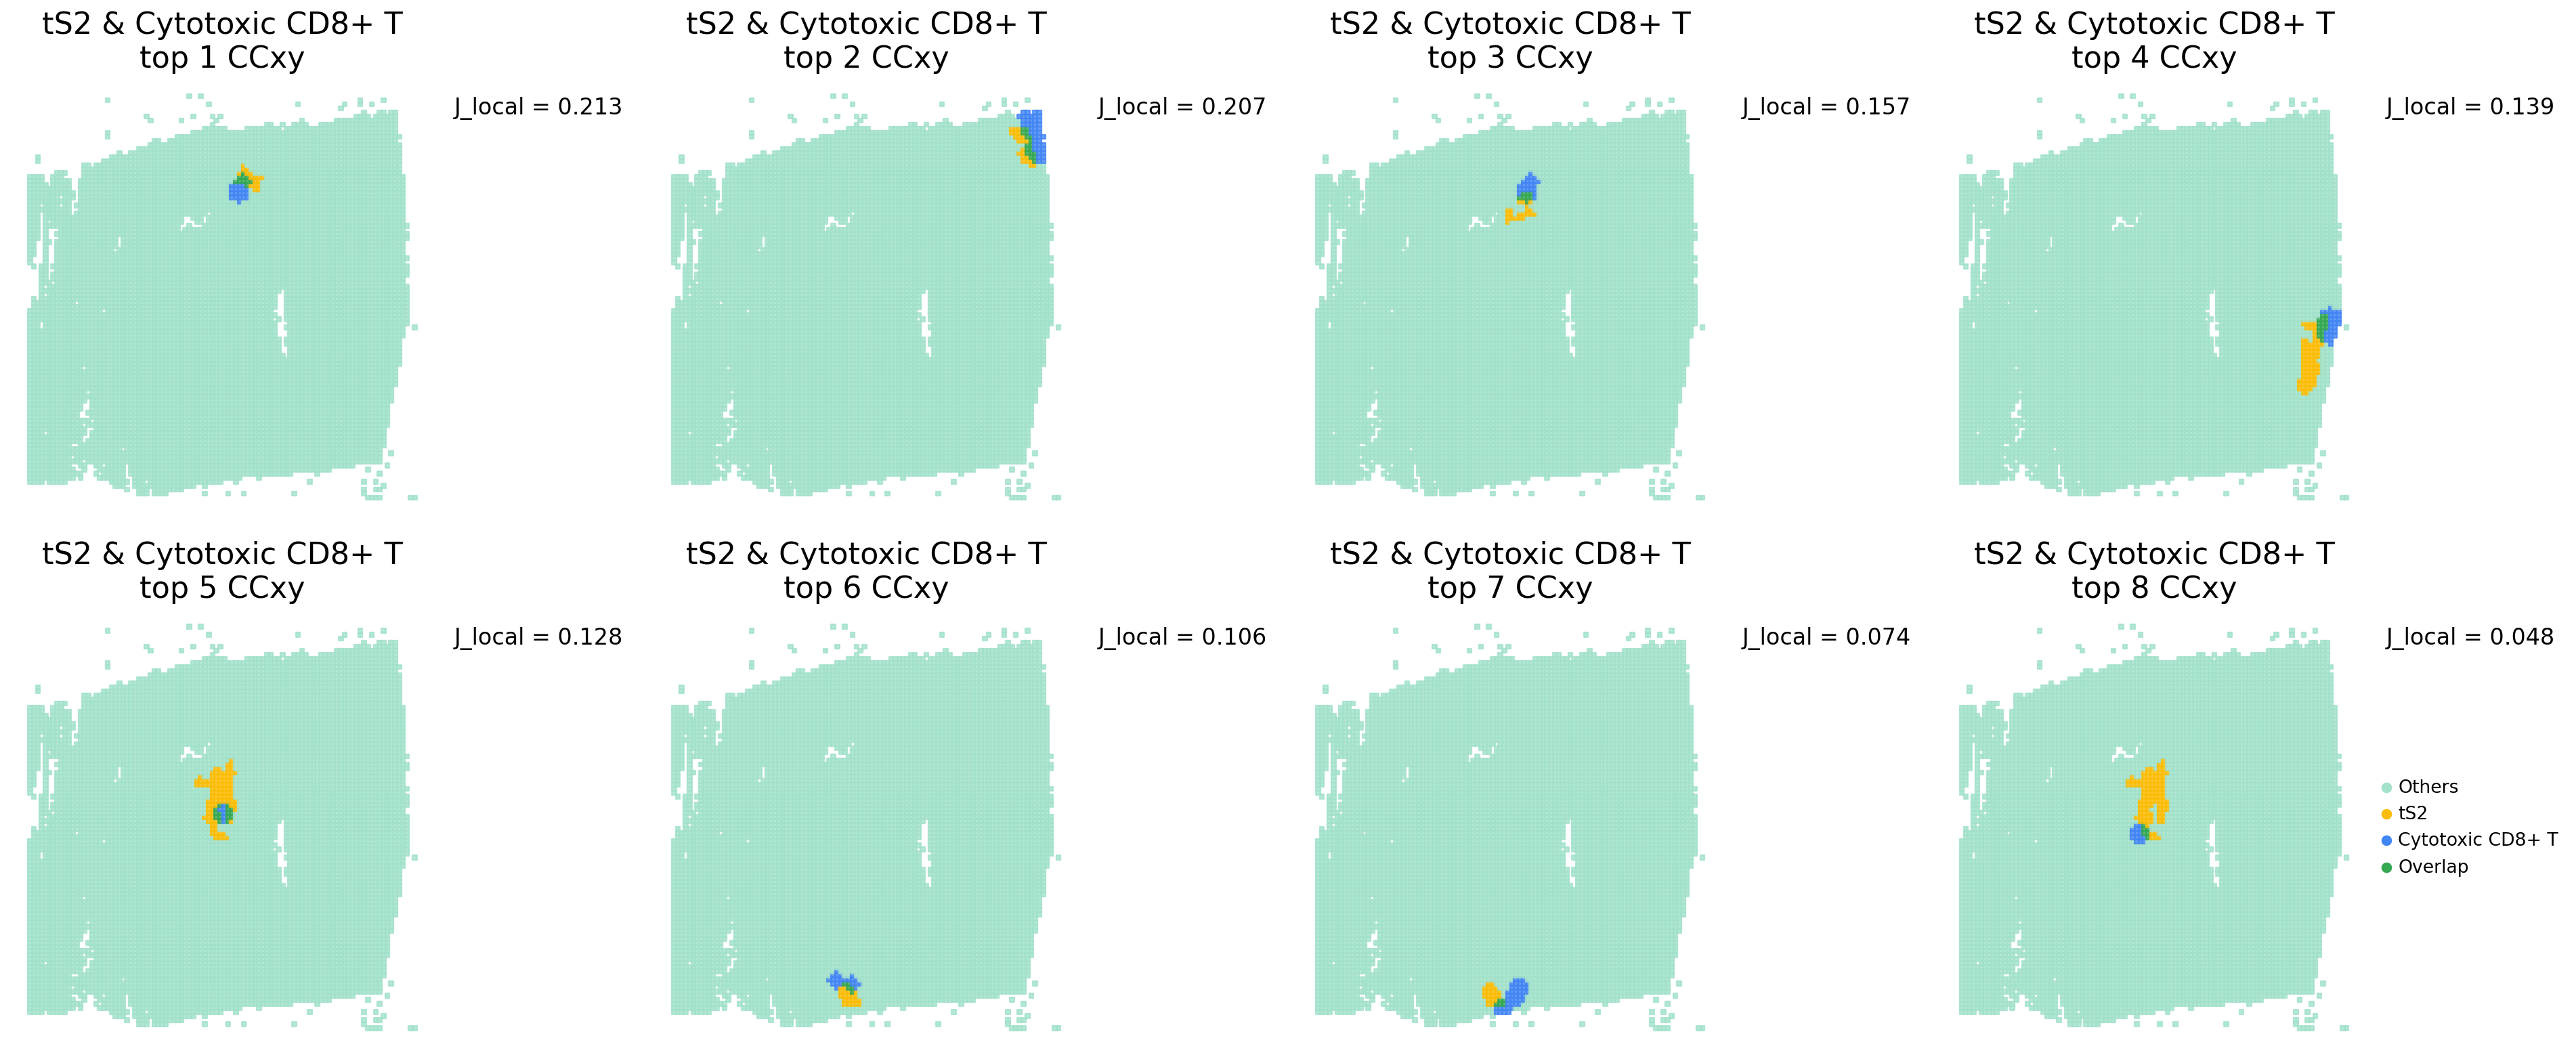

In [27]:
sp_adata.vis_jaccard_top_n_pair(feat_name_x='tS2', feat_name_y='Cytotoxic CD8+ T',
                                top_n = 8, ncol = 4, alpha = 0.8, dot_size=3,
                                fig_size = (6,5), title_fontsize = 20, legend_fontsize = 12,
                                title = '', return_axis=False, save=True, dpi=200)

#### 2. Extract colocalized regions btw LR pairs 
##### (CellTalk DB)

##### Extract colocalization patterns between LR pairs

In [28]:
sp_adata.topological_similarity(use_lr_db=True, lr_db_species='human', J_result_name='result')

Using CellTalk ligand-receptor dataset
End of data preparation
Elapsed time: 0.45 seconds 
Calculation of adjacency matrix and mask


  0%|          | 0/1 [00:00<?, ?it/s]

Calculation of connected components for each feature


  0%|          | 0/30 [00:00<?, ?it/s]

Calculation of composite jaccard indexes between feature pairs


  0%|          | 0/19 [00:00<?, ?it/s]

End of the whole process: 30.60 seconds


##### Save STopover object to the save_dir

In [29]:
sp_adata.save_connected_loc_data(save_format='h5ad', filename = 'sp_grid_lr_interact')

Saving anndata in .uns separately as .h5ad: adata_cell


##### Visualize feature map for LR pairs

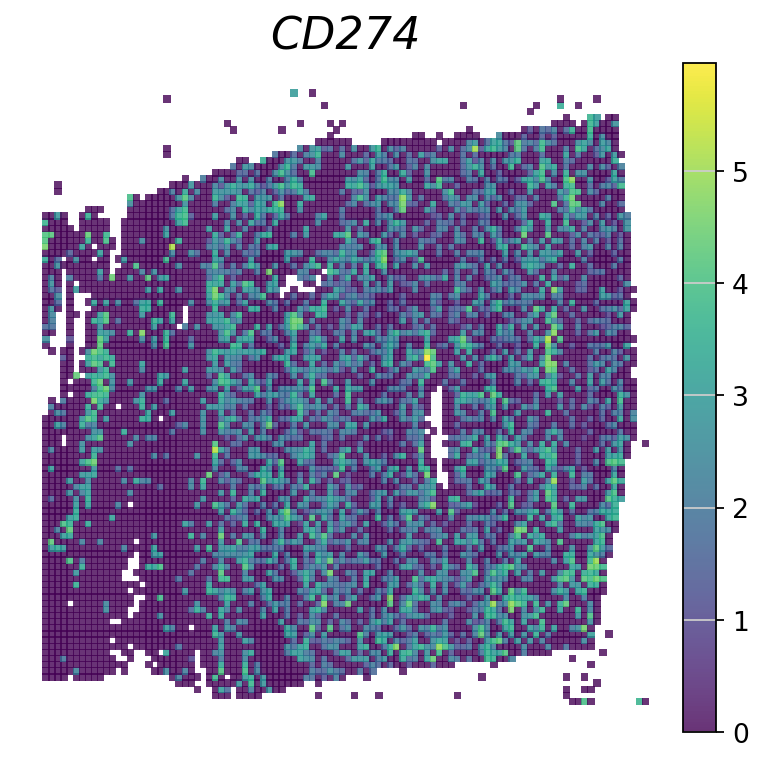

In [30]:
sp_adata.vis_spatial_imageST(feat_name='CD274', fig_size=(5,5), title_fontsize=20, 
                             legend_fontsize=12, save=True, return_axis=False,  dpi=200)

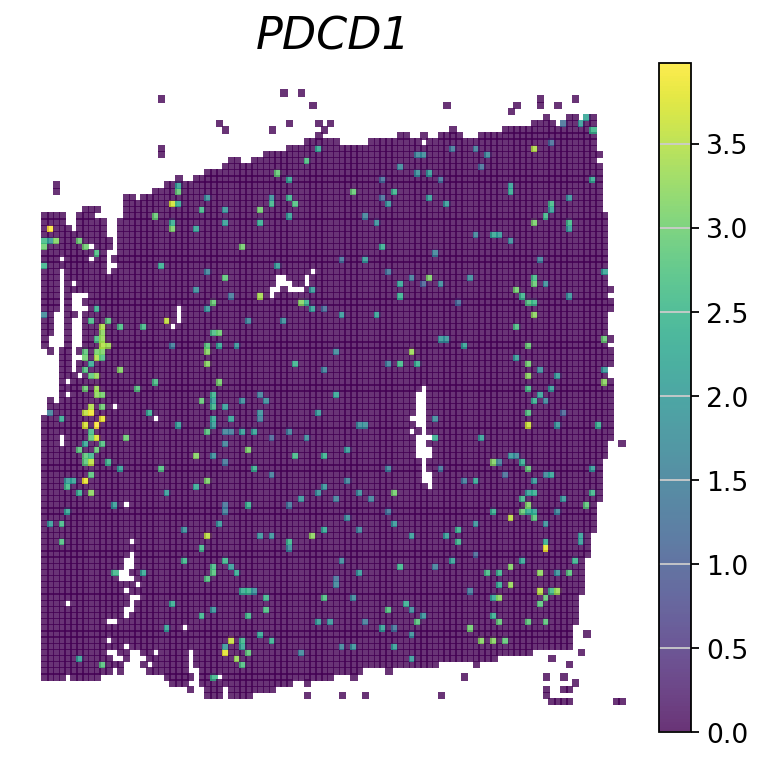

In [31]:
sp_adata.vis_spatial_imageST(feat_name='PDCD1', fig_size=(5,5), title_fontsize=20, 
                             legend_fontsize=12, save=True, return_axis=False,  dpi=200)

##### Visualize colocalized regions of LR

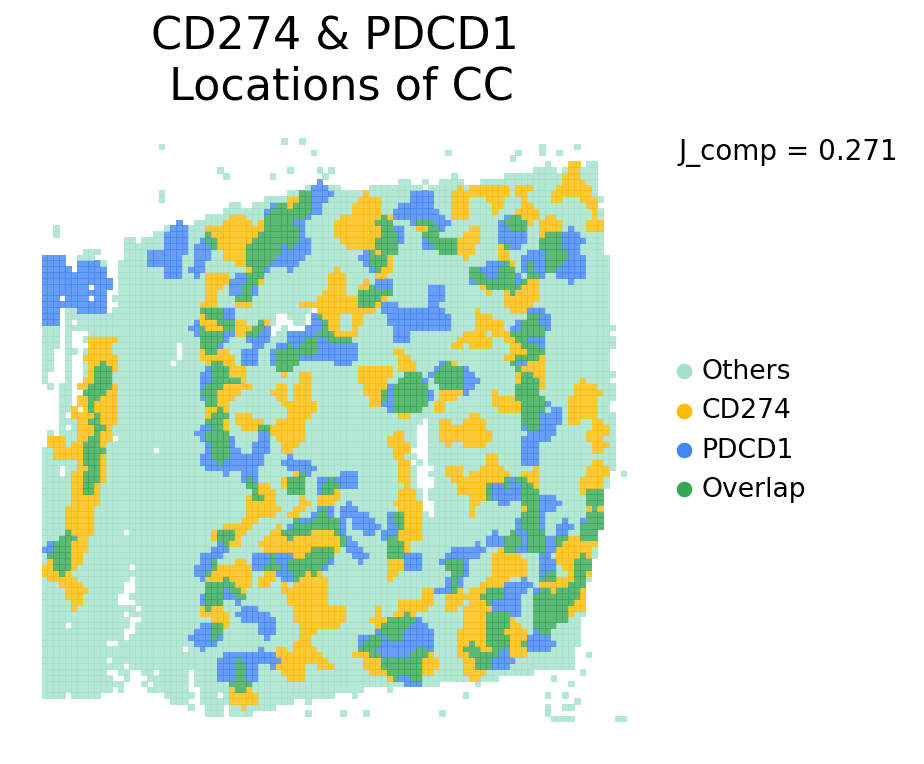

In [32]:
sp_adata.vis_all_connected(feat_name_x='CD274', feat_name_y='PDCD1',
                           alpha = 0.8, dot_size=3,
                           fig_size=(6,5), title_fontsize = 20, legend_fontsize = 12, 
                           title = '\n Locations of CC', return_axis=False, save=True, dpi=200)

##### Visualize top 8 regions with high local overlap

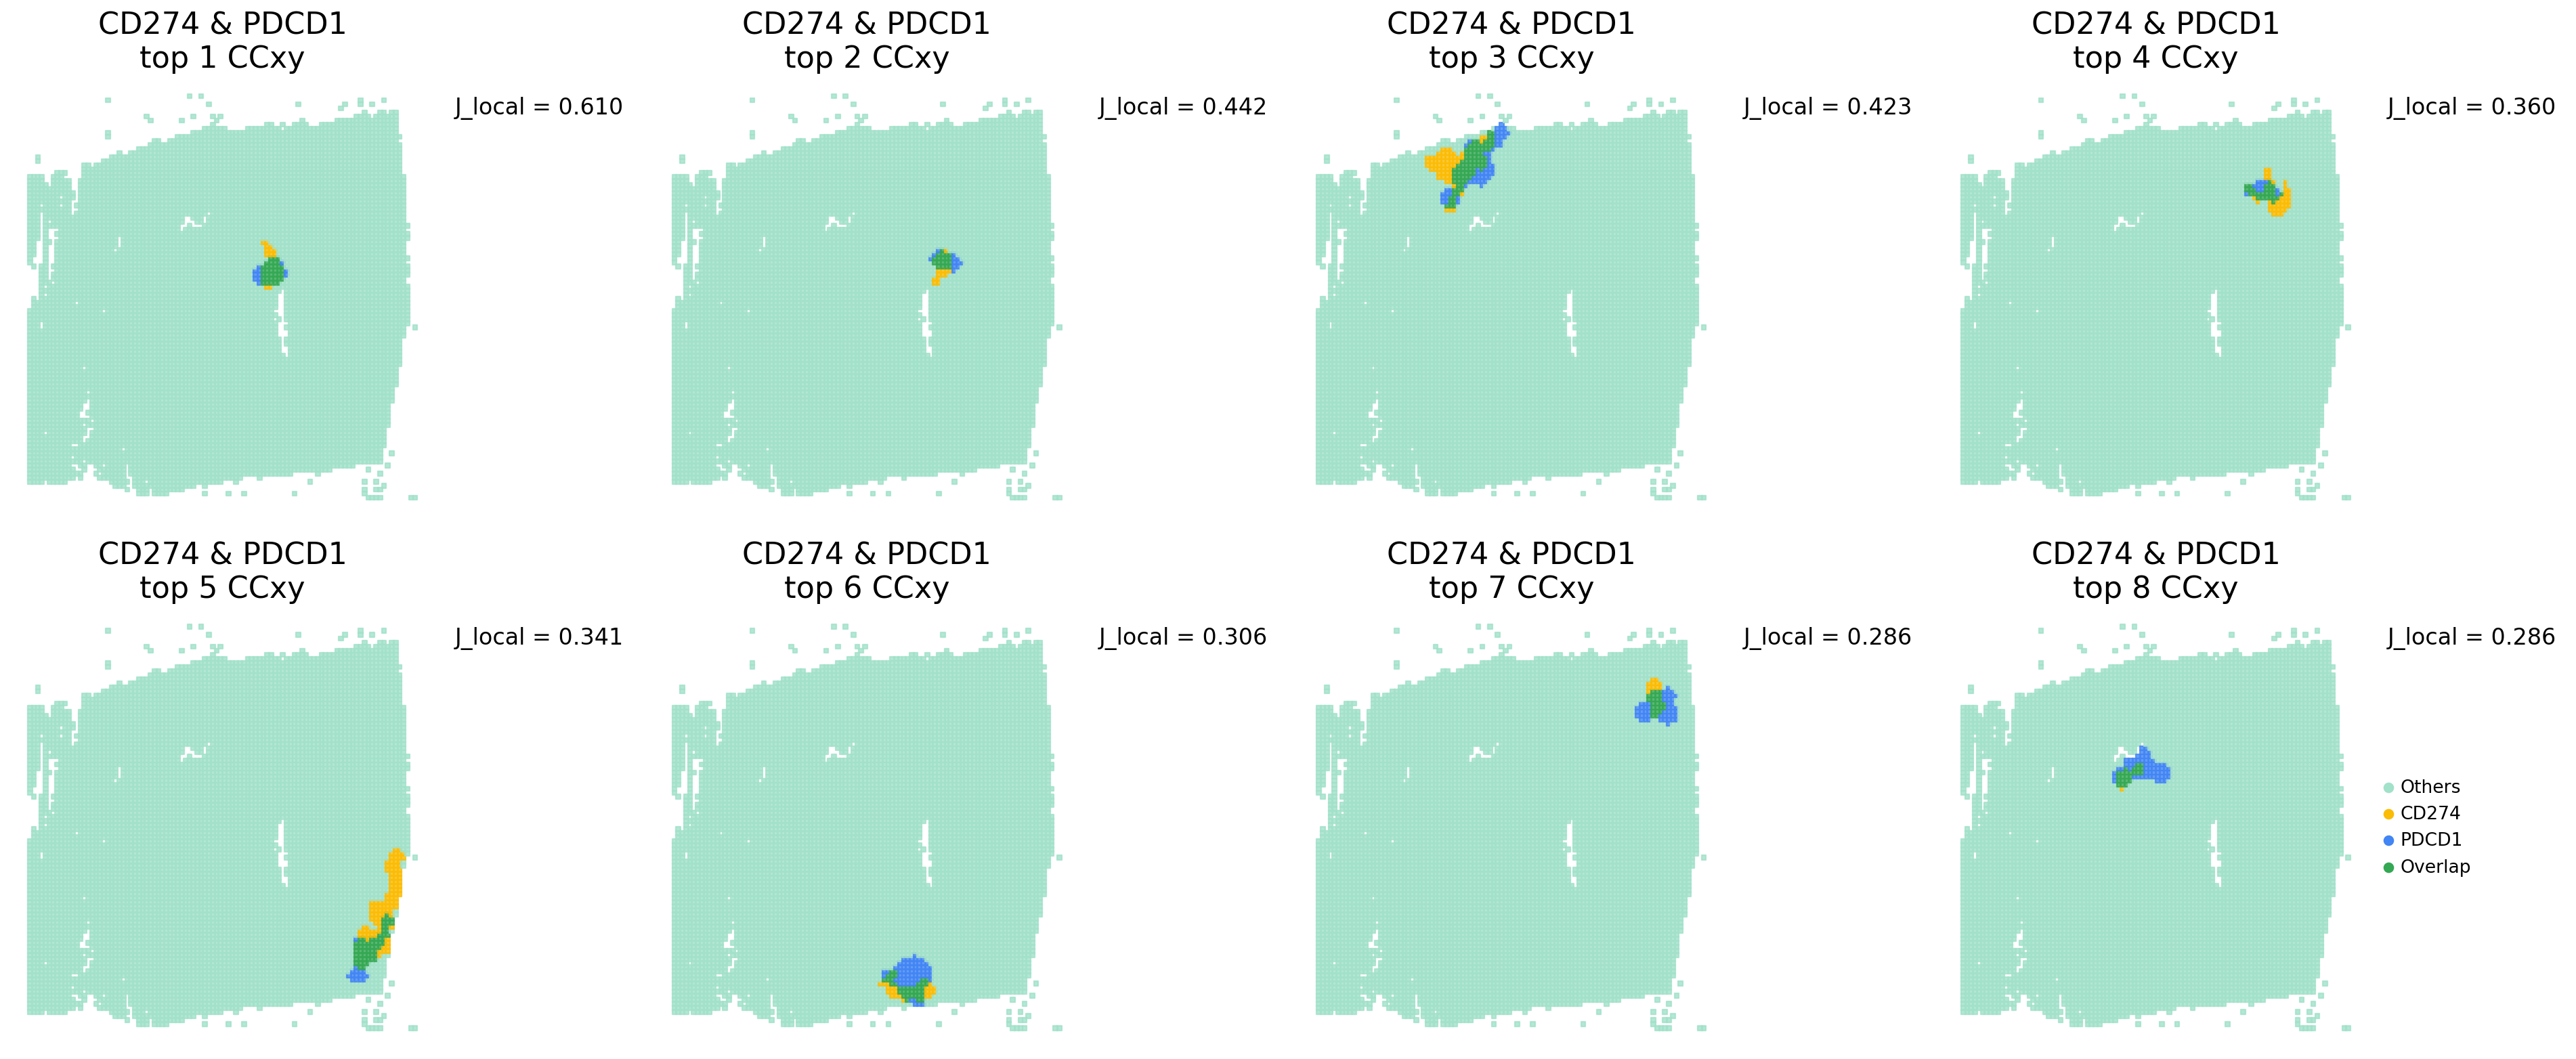

In [33]:
sp_adata.vis_jaccard_top_n_pair(feat_name_x='CD274', feat_name_y='PDCD1',
                                top_n = 8, ncol = 4, alpha = 0.8, dot_size=3,
                                fig_size = (6,5), title_fontsize = 20, legend_fontsize = 12,
                                title = '', return_axis=False, save=True, dpi=200)

#### 3. Estimate cell-type specific L-R interaction

##### Load saved STopover object for cell-type specific analysis

In [34]:
sp_adata = STopover_imageST(sp_load_path=os.path.join(save_dir, 'sp_grid_celltype_interact_adata.h5ad'), 
                            x_bins=100, y_bins=100, min_size=20, fwhm=2.5, thres_per=30, save_path=save_dir)

Anndata object is not provided: searching for the .h5ad file in 'sp_load_path'


##### Caculate cell-type specific expession

In [35]:
sp_adata_ts2, sp_adata_cd8 = sp_adata.celltype_specific_adata(cell_types=['tS2','Cytotoxic CD8+ T'])

In [36]:
sp_adata_ts2, sp_adata_cd8

(STopover_imageST object with n_obs × n_vars = 7881 × 377
     obs: 'array_col', 'array_row'
     uns: 'x_bins', 'y_bins', 'ST_type', 'grid_method', 'sc_celltype_colname', 'transcript_colname', 'sc_norm_total', 'min_counts', 'min_cells', 'min_size', 'fwhm', 'thres_per', 'obs_',
 STopover_imageST object with n_obs × n_vars = 7881 × 377
     obs: 'array_col', 'array_row'
     uns: 'x_bins', 'y_bins', 'ST_type', 'grid_method', 'sc_celltype_colname', 'transcript_colname', 'sc_norm_total', 'min_counts', 'min_cells', 'min_size', 'fwhm', 'thres_per', 'obs_')

##### Extract cell type-specific L-R colocalization patterns

In [37]:
sp_adata_ts2_cd8 = sp_adata.topological_similarity_celltype_pair(celltype_x='tS2', celltype_y='Cytotoxic CD8+ T',
                                                                 use_lr_db=True, lr_db_species='human', J_result_name='result')

Calculating topological similarity between genes in 'tS2' and 'Cytotoxic CD8+ T'
Using CellTalk ligand-receptor dataset
End of data preparation
Elapsed time: 0.02 seconds 
Calculation of adjacency matrix and mask


  0%|          | 0/1 [00:00<?, ?it/s]

Calculation of connected components for each feature


  0%|          | 0/30 [00:00<?, ?it/s]

Calculation of composite jaccard indexes between feature pairs


  0%|          | 0/19 [00:00<?, ?it/s]

End of the whole process: 17.18 seconds


##### Save STopover object to the save_dir

In [38]:
sp_adata_ts2_cd8.save_connected_loc_data(save_format='h5ad', filename = 'cc_loc_smi_lr')

##### Load J_comp list for all cell-type specific LR pairs

In [39]:
sp_adata_ts2_cd8.uns.keys()

odict_keys(['x_bins', 'y_bins', 'ST_type', 'grid_method', 'sc_celltype_colname', 'transcript_colname', 'sc_norm_total', 'min_counts', 'min_cells', 'min_size', 'fwhm', 'thres_per', 'J_result_1'])

In [40]:
J_result = sp_adata_ts2_cd8.uns['J_result_1']
J_result.sort_values(by=['J_comp'], ascending=False)

group       Feat_1                       Feat_2     Avg_1     Avg_2  \
17     0    tS2: EDN1      Cytotoxic CD8+ T: EDNRB  1.209234  0.048812   
9      0    tS2: KNG1       Cytotoxic CD8+ T: CD93  1.776374  0.140777   
16     0    tS2: EDN1     Cytotoxic CD8+ T: ADGRL4  1.209234  0.075196   
18     0     tS2: INS     Cytotoxic CD8+ T: LILRB2  0.089345  0.075453   
2      0    tS2: CD70       Cytotoxic CD8+ T: CD27  0.074454  0.214480   
0      0   tS2: CXCL6      Cytotoxic CD8+ T: ACKR1  1.612400  0.018842   
7      0    tS2: VCAN       Cytotoxic CD8+ T: SELL  1.122336  0.048901   
11     0     tS2: GCG      Cytotoxic CD8+ T: RAMP2  0.196459  0.014651   
15     0    tS2: CCL5      Cytotoxic CD8+ T: ACKR1  1.587209  0.018842   
13     0    tS2: CD86       Cytotoxic CD8+ T: CD28  1.701838  0.199263   
10     0   tS2: CCL19       Cytotoxic CD8+ T: CCR7  0.173271  0.047616   
8      0    tS2: CD34       Cytotoxic CD8+ T: SELL  1.996111  0.048901   
6      0    tS2: CD70   Cytotoxic CD8+ T: TNFRSF17  0.074454  0.029202   
14     0   tS2: CD274      Cytotoxic CD8+ T: PDCD1  0.502419  0.011389   
4      0     tS2: TNC       Cytotoxic CD8+ T: EGFR  1.735046  0.010893   
5      0  tS2: S100A1       Cytotoxic CD8+ T: AGER  2.188375  0.004894   
1      0    tS2: CD70  Cytotoxic CD8+ T: TNFRSF13B  0.074454  0.012780   
12     0    tS2: CD86      Cytotoxic CD8+ T: CTLA4  1.701838  0.041194   
3      0    tS2: VCAN       Cytotoxic CD8+ T: EGFR  1.122336  0.010893   

      J_comp  
17  0.065566  
9   0.064630  
16  0.055556  
18  0.049082  
2   0.042903  
0   0.025043  
7   0.023906  
11  0.022327  
15  0.020333  
13  0.019965  
10  0.019638  
8   0.015704  
6   0.012586  
14  0.004354  
4   0.000000  
5   0.000000  
1   0.000000  
12  0.000000  
3   0.000000

##### Visualize cell type-specific feature map

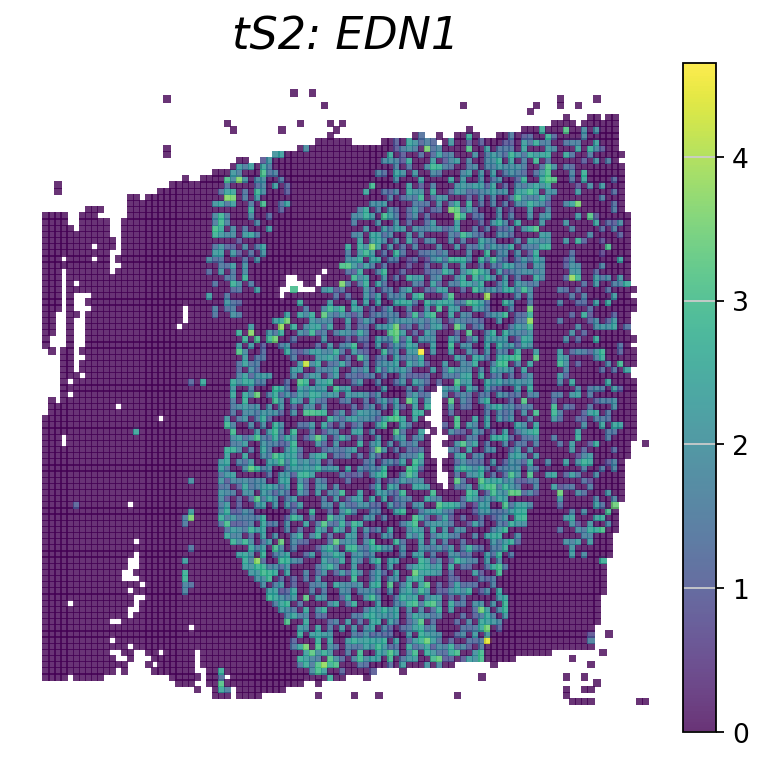

In [50]:
sp_adata_ts2.vis_spatial_imageST(feat_name='EDN1', title = 'tS2: ', fig_size=(5,5), title_fontsize=20, 
                                 legend_fontsize=12, save=True, return_axis=False, dpi=200)

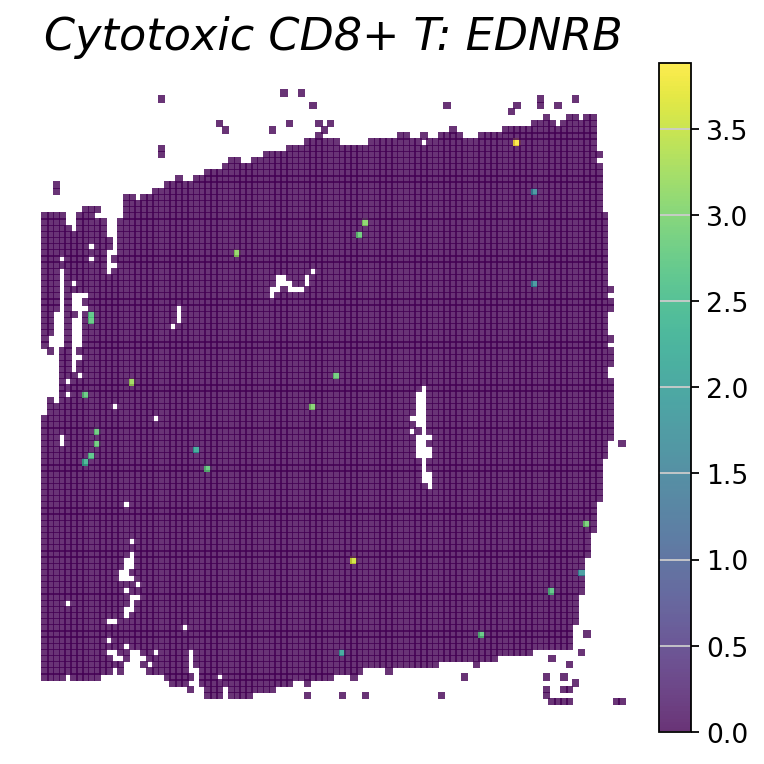

In [51]:
sp_adata_cd8.vis_spatial_imageST(feat_name='EDNRB', title = 'Cytotoxic CD8+ T: ', fig_size=(5,5), title_fontsize=20, 
                                 legend_fontsize=12, save=True, return_axis=False, dpi=200)

##### Visualize colocalized regions of a cell type-specific LR

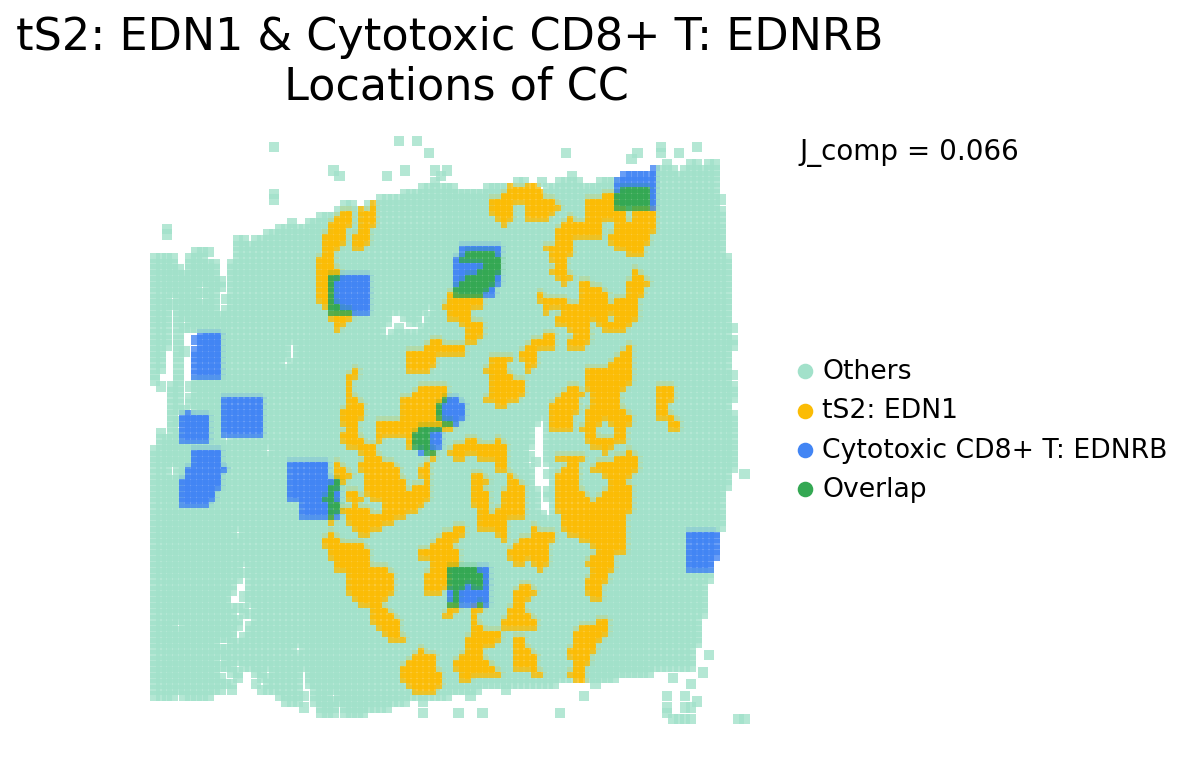

In [52]:
sp_adata_ts2_cd8.vis_all_connected(feat_name_x='tS2: EDN1', feat_name_y='Cytotoxic CD8+ T: EDNRB',
                                   alpha = 0.8, 
                                   fig_size=(7,5), title_fontsize = 20, legend_fontsize = 12, 
                                   title = '\n Locations of CC', return_axis=False, save=True)

##### Visualize top 4 regions with high local overlap

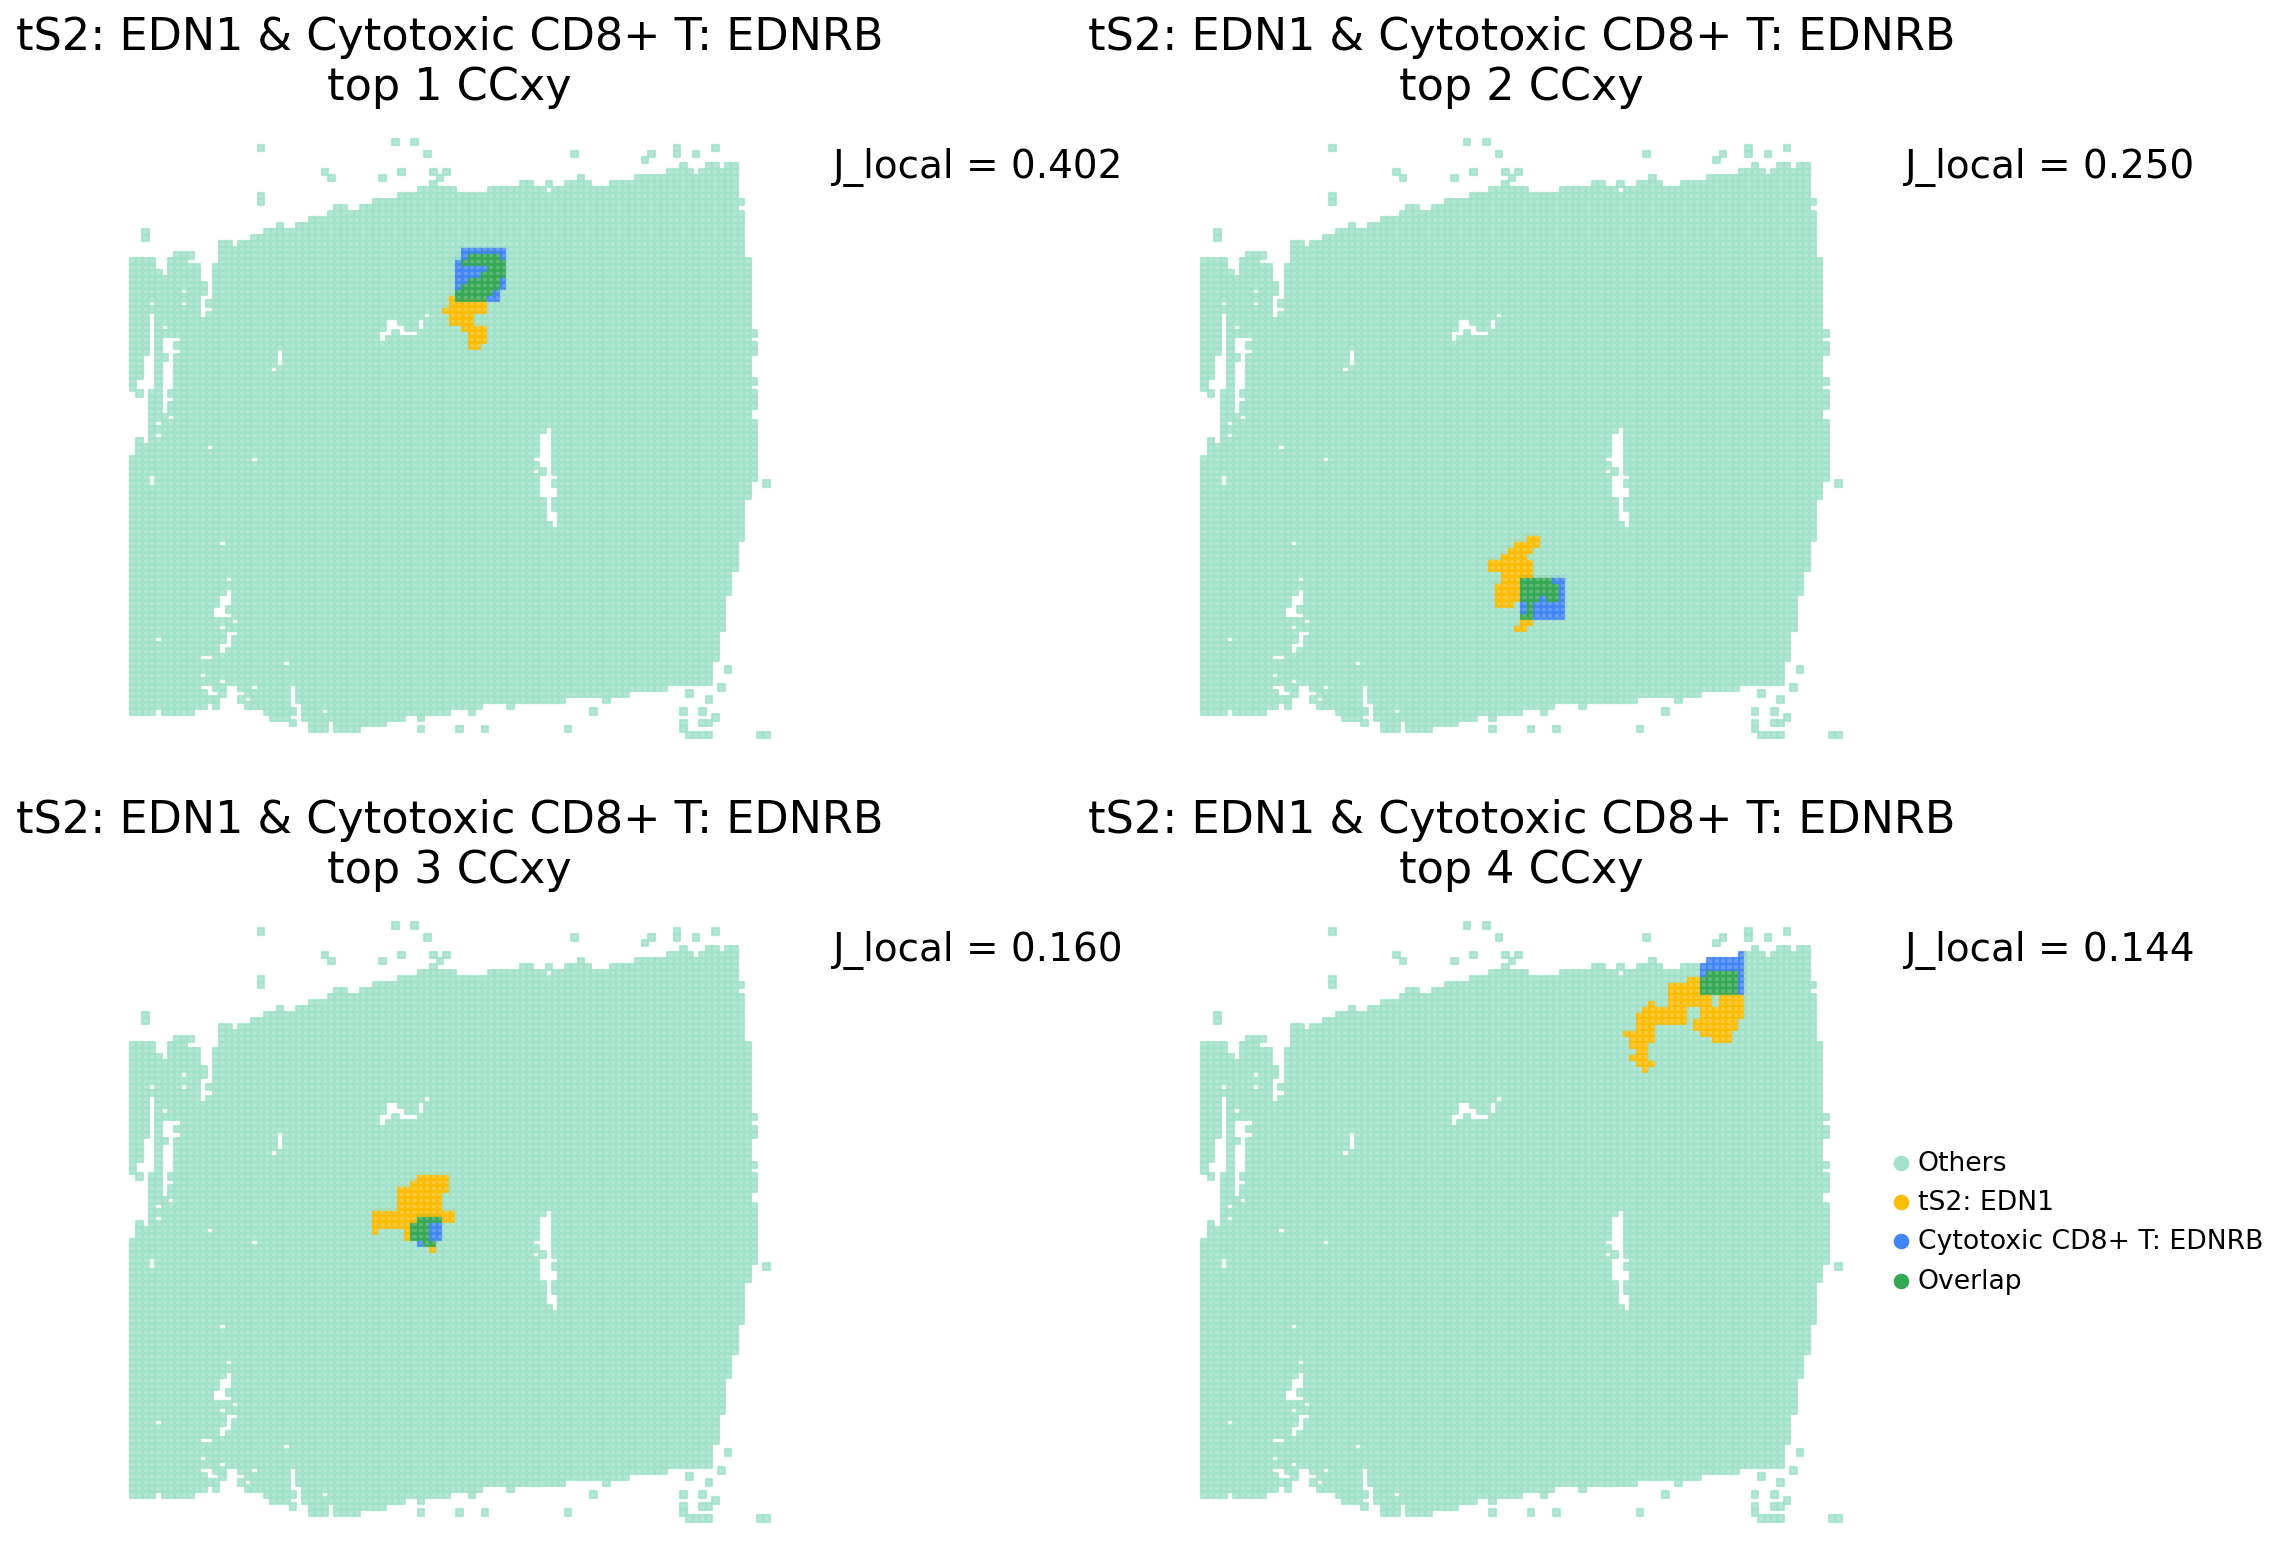

In [53]:
sp_adata_ts2_cd8.vis_jaccard_top_n_pair(feat_name_x='tS2: EDN1', feat_name_y='Cytotoxic CD8+ T: EDNRB',
                                        top_n = 4, ncol = 2, alpha = 0.8, dot_size=3,
                                        fig_size = (7,5), title_fontsize = 20, legend_fontsize = 12,
                                        title = '', return_axis=False, save=True, dpi=200)